# BIOMEDIN 260/RAD260: Problem Set 3 - Mammogram Project

## Spring 2020

## Name: Yiheng Li

**Deadline = May 29 11:00 PM**

## Introduction

Breast cancer has the highest incidence and second highest mortality rate for women in the US.

Your task is to utilize machine learning to study mammograms in any way you want (e.g. classification, segmentation) as long as you justify why it is useful to do whatever it is you want to do. Turning in a deep dream assignment using mammograms might be amusing, for example, but not so useful to patients. That being said, choose something that interests you. As the adage goes, "do what you love, and you’ll never have to work another day in your life, at least in BMI 260."

Treat this as a mini-project. We highly encourage working with 1 other person, possibly someone in your main project team. 

In addition to the mammograms themselves, the dataset includes "ground-truth" segmentations and `mass_case_description_train_set.csv`, which contains metadata information about mass shapes, mass margins, assessment numbers, pathology diagnoses, and subtlety in the data. Take some time to research what all of these different fields mean and how you might utilize them in your work. You dont need to use all of what is provided to you.

Some ideas:

1. Use the ROI’s or segmentations to extract features, and then train a classifier based on those features using the algorithms presented to you in the machine learning lectures (doesn't need to use deep learning).

2. Use convolutional neural networks. Feel free to use any of the code we went over in class or use your own (custom code, sklearn, keras, Tensorflow etc.). If you dont want to place helper functions and classes into this notebook, place them in a `.py` file in the same folder called `helperfunctions.py` and import them into this notebook.

## Data

The data is here:

https://wiki.cancerimagingarchive.net/display/Public/CBIS-DDSM

## Grading and Submission

This assignment has 3 components: code, figures (outputs/analyses of your code), and a write-up detailing your mini-project. You will be graded on these categories.

If you're OK with Python or R, please place all three parts into this notebook/.Rmd file that we have provided where indicated. We have written template sections for you to follow for simplicity/completeness. When you're done, save as a `.pdf` (please knit to `.pdf` if you are using `.Rmd`, or knit to `.html` and use a browser's "Print" function to convert to `.pdf`).

If you don't like Python OR R, we will allow you to use a different language, but please turn your assignment in with: 1) a folder with all your code, 2) a folder with all your figures, and 3) a `.tex`/`.doc`/`.pdf` file with a write-up.

In [1]:
# Loading packages
from tqdm import tqdm
from keras_tqdm import TQDMCallback
import h5py
import os
import matplotlib.pyplot as plt
from matplotlib.image import imsave
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from tensorflow.keras.models import load_model
from skimage.transform import resize
from sklearn.calibration import calibration_curve

Using TensorFlow backend.


## Mammogram Classification and Uncertainty Analysis to Optimize Reveiw Workflow

In [2]:
# Util functions
def getImageList(rel_path, verbose=False):
    """
    Input relative path, get all the images from 'rel_path\\patient ID\\image names'
    input: relative path
    output: df(patient number, image file name list, image file dir list)
    """
    patient_num_list = []
    img_name_list = []
    img_path_list = []
    # Get all the image paths and names
    cur_path = os.path.abspath('')
    data_path = os.path.join(cur_path, rel_path)
    p_folder_list = os.listdir(data_path)
    for p_folder in p_folder_list:
        img_dir = os.path.join(data_path, p_folder)
        img_list = os.listdir(img_dir)
        for img_name in img_list:
            img_path = os.path.join(img_dir, img_name)
            patient_num_list += [p_folder]
            img_name_list += [img_name]
            img_path_list += [img_path]
    assert len(patient_num_list) == len(img_path_list), 'Lengths differ.'
    df = pd.DataFrame(list(zip(patient_num_list, img_name_list, img_path_list)),
                columns = ['patient number', 'img name', 'img path'])
    return df

def loadOneImage(img_path):
    hf = h5py.File(img_path, 'r')
    img = hf['data'][()]
    return img

# intergrated function to load images and do 
# preprocessing to the images loaded
def loadImages(img_path_list, size = None):
    assert len(img_path_list)>0, 'No files to load'
    # image example
    example = loadOneImage(img_path_list[0])
    img_shape = list(example.shape)
    if size is not None: 
        ar_shape = tuple([len(img_path_list)]+list(size)+[3])
        imgs = np.zeros(ar_shape)
        for i in tqdm(range(len(img_path_list))):
            imgs[i] = makeRgb(resize(image = loadOneImage(img_path_list[i])[:,:,0], output_shape = size))
    else: 
        ar_shape = tuple([len(img_path_list)] + img_shape[0:2]+[3])
        imgs = np.zeros(ar_shape)
        for i in tqdm(range(len(img_path_list))):
            imgs[i] = makeRgb(loadOneImage(img_path_list[i])[:,:,0])
    return imgs

# Preprocess Image
# Scale to 0 - 255
def imgScale(img):
    img -= np.min(img)
    img *= 255/np.max(img)
    return img.astype('int')

# "Make" RGB
def makeRgb(img):
    """ input: 2D img; output: img w/ 3 channels identical """
    new_img = np.repeat(np.expand_dims(img, axis=-1), repeats=3, axis=-1)
    return new_img

def plotReliability(probs, y_test, n_bins = 10):
    # reliability diagram
    fop, mpv = calibration_curve(y_test, probs, n_bins=n_bins)
    # plot perfectly calibrated
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot model reliability
    plt.plot(mpv, fop, marker='.')
    plt.show()
    
def getFeatrues(scaled_imgs):
    features = np.zeros((len(scaled_imgs), 1024))
    for i in tqdm(range(len(scaled_imgs))):
        feature = getOutput(scaled_imgs[i:i+1])
        features[i] = feature
    return features

**1. Describe what you are doing and why it matters to patients using at least one citation.**

Traditional mammogram classification requires extra annotations such as bounding box of detection or like in our dataset, mask ground truch for segmentation, which requires a lot of work by the radiologists. And plus, classification of the lesions after having ROI or segmentation is also difficult which requires high expertise and time[<sup>1</sup>](#s1). Nowadays, machine learning appoaches, particularly deep learning, are widly utilized to improve computer-aided diagnosis (CAD) and decision report[<sup>2</sup>](#s2). Most popular methods seek to improve detection performances, but they didn't necessarily provide reliability of their prediction, which stil requires the interaction by an expert raiologist[<sup>3</sup>](#s3).

This study aims to provide a potential feasible direction to ease the burden of radiologists by providing not the exact label classifications from machine learning models. But utilize models to excluded consirable proportion of mammograms which were believed to be very confidently classified. And left the rest to be further reviewed by radiologists.

**2. Describe the relevant statistics of the data. How were the images taken? How were they labeled? What is the class balance and majority classifier accuracy? How will you divide the data into testing, training and validation sets?**

### Image statistics

#### 1. Perspectives of images

In [3]:
img_info = getImageList('data_fixed_crop_w_mask')
img_info.head()

,patient number,img name,img path
0,00001,LEFT_CC.h5,G:\Code\BIOMEDIN260\Problem Set 3\data_fixed_c...
1,00001,LEFT_MLO.h5,G:\Code\BIOMEDIN260\Problem Set 3\data_fixed_c...
2,00004,LEFT_CC.h5,G:\Code\BIOMEDIN260\Problem Set 3\data_fixed_c...
3,00004,LEFT_MLO.h5,G:\Code\BIOMEDIN260\Problem Set 3\data_fixed_c...
4,00004,RIGHT_CC.h5,G:\Code\BIOMEDIN260\Problem Set 3\data_fixed_c...


Actually we can see that for each patient, there are multiple images related to them, and each of them are named based on the perspective. In order to have the complete list of all the perspectives of the images, we take the unique values of image names.

In [4]:
print(img_info['img name'].unique())

['LEFT_CC.h5' 'LEFT_MLO.h5' 'RIGHT_CC.h5' 'RIGHT_MLO.h5']


So all the images are taking from left or the right with bilateral craniocaudal (CC) or mediolateral oblique (MLO) views.

In [5]:
# Build a DataFrame
description = pd.read_csv('mass_case_description_train_set.csv')
fn = lambda x: 'P_' + x
patient_id = img_info['patient number'].apply(fn)
patient_id.name = 'patient_id'
pred_info = pd.concat([patient_id, img_info['patient number'], img_info['img path']], axis = 1)
pred_info = pd.merge(pred_info, description[['patient_id', 'pathology']], on='patient_id', how='inner')
print(pred_info.shape)
pred_info.head()

(2085, 4)


,patient_id,patient number,img path,pathology
0,P_00001,00001,G:\Code\BIOMEDIN260\Problem Set 3\data_fixed_c...,MALIGNANT
1,P_00001,00001,G:\Code\BIOMEDIN260\Problem Set 3\data_fixed_c...,MALIGNANT
2,P_00001,00001,G:\Code\BIOMEDIN260\Problem Set 3\data_fixed_c...,MALIGNANT
3,P_00001,00001,G:\Code\BIOMEDIN260\Problem Set 3\data_fixed_c...,MALIGNANT
4,P_00004,00004,G:\Code\BIOMEDIN260\Problem Set 3\data_fixed_c...,BENIGN


We can see after matching the labels with their images, we 2085 images with labels.

#### 2. Labels of images

In [6]:
print(pred_info['pathology'].unique())
labels = pred_info['pathology'] == 'MALIGNANT'

['MALIGNANT' 'BENIGN' 'BENIGN_WITHOUT_CALLBACK']


All the images contain three kinds of labels. Benign without callback indicates that a physician marked some aspect of the case as worth tracking, but did not require further followup[<sup>4</sup>](#s4). We set class `'MALIGNANT'` as 1, while the other two classes are set to 0.

#### 3. Majority classifier accuracy

The majority classifier accuracy is given by the proportion of the majority cases in the dataset.

In [7]:
# proportion of positive cases (malignant)
pos_ratio = np.mean(pred_info['pathology'] == 'MALIGNANT')
print('proportion of positive cases = ', pos_ratio)
# So the accuracy would be
print('So the accuracy = ', 1 - pos_ratio)

proportion of positive cases =  0.47817745803357314
So the accuracy =  0.5218225419664269


#### 4. Data division

The `train_test_split` function is used to do the feature selection. I chose test set to have 15% of the data.

**3. Describe your data pipeline (how is the data scrubbed, normalized, stored, and fed to the model for training?).**

1. Image resize: In `loadImages` function, if size parameter is set, then the image will be loaded as the specified size. Multiple kinds of sizes are considered and the original size (256, 256) works fine.
2. Mask remove: Masks of the image are automatically removed by `loadOneImage` function. To just keep the greyscale image for further analysis.
3. RGB conversion: Greyscale images are converted to 3 channel-RGB images by duplicating the grey channel three times.
4. Image rescale: All images are rescale to 0-255 integer data type.
5. Image Storage: All images are loaded as an `ndarray` by `numpy`. There are four dimensions in total, which are respectively (n_examples, image_width, image_height, channels)

In [8]:
# laod all images in a ndarry and rescale all the images to be `scaled_imgs`.
imgs = loadImages(pred_info['img path'])
scaled_imgs = imgScale(imgs)
# The shape of X
print(scaled_imgs.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 2085/2085 [00:22<00:00, 92.71it/s]


(2085, 256, 256, 3)


**4. Explain how the model you chose works alongside the code for it. Add at least one technical citation to give credit where credit is due.**

This study started with a model mensioned in an published article, which is an "end-to-end" classification model that requires only image level label to train and can achieve high performance[<sup>5</sup>](#s5). A pre-trained model is taken and used to give predictions and image features.

In [9]:
# load the pre-trained model
resmodel = load_model('ddsm_resnet50_s10_[512-512-1024]x2.h5')
# And try to make prediction using this model
preds_matrix = resmodel.predict(scaled_imgs)
preds = preds_matrix[:,1]

In [10]:
# Brief summary of the prediction results
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, plot_confusion_matrix
print('The confusion matrix of the model predictions on our dataset.')
print(confusion_matrix(labels, preds > 0.5))
print('The accuracy of the model prediction.')
print(round(accuracy_score(labels, preds > 0.5), 4))
print('The AUCROC of the model prediction.')
print(round(roc_auc_score(labels, preds > 0.5), 4))

The confusion matrix of the model predictions on our dataset.
[[860 228]
 [376 621]]
The accuracy of the model prediction.
0.7103
The AUCROC of the model prediction.
0.7067


We can see that this model is doing fairly good in three results. However, when we look at the calibration reliability curve, the result is not that satisfying.

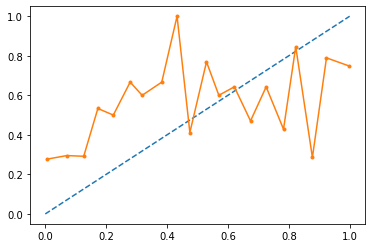

In [11]:
plotReliability(preds, labels, n_bins=20)

**5. There are many ways to do training. Take us through how you do it (e.g. "We used early stopping and stopped when validation loss increased twice in a row.").**

The output layer was removed from the original model. The output of the last hidden layer which consist of 1024 values were taken as codings of images. Using the coding information, a support vector machine was trained on training set and evaluated on test set. The goal is that we want this SVM to be well calibratred, using `CalibratedClassifierCV` function by `sklearn`.

In [12]:
# get output
from tensorflow.keras.models import clone_model, Sequential
from keras import backend as K
getOutput = K.function(resmodel.layers[0].input, resmodel.layers[-2].output)
features = getFeatrues(scaled_imgs)
# Look at the shape of features extracted
print(features.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 2085/2085 [01:21<00:00, 25.65it/s]

(2085, 1024)


In [13]:
# Train a classifier and calibrate it
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
clf = SVC()
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=9001)
calibrator = CalibratedClassifierCV(clf, method = 'sigmoid', cv=5)
_ = calibrator.fit(x_train, y_train)

In [14]:
# Get predict probability from SVM
probs = calibrator.predict_proba(x_test)[:, 1]

In [15]:
accuracy_score(y_test, probs > 0.5)

0.7170263788968825

**6. Make a figure displaying your results.**

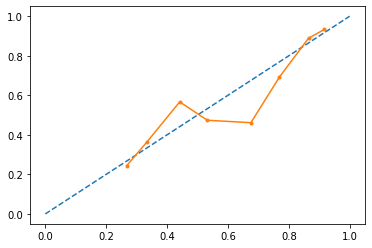

In [16]:
# Plots of calibrated SVM
plotReliability(probs, y_test)

What if we want the algorithm to exclude all the mammograms that score higher than 0.8. Let's compare the results before and after calibration.

In [17]:
print('There are {} patients in \'y_test\', and {} patients have > 0.8 score.'.format(len(y_test), np.sum(probs > 0.8)))
print('The excluded mammogram will have {} accuracy and reduce the workload of expert radiologists by {}%'.format(round(np.mean(y_test[probs > 0.8]), 4), round(np.sum(probs > 0.8) / len(y_test) * 100, 2)))

There are 417 patients in 'y_test', and 96 patients have > 0.8 score.
The excluded mammogram will have 0.8958 accuracy and reduce the workload of expert radiologists by 23.02%


**7. Discuss pros and cons of your method and what you might have done differently now that you've tried or would try if you had more time.**

This study did provide a potential feasible direction to explore which could help reduce the workload of expert radiologists so that they can spend more energy and time to focus on the more difficult mammograms to reduce misclassification finally.

There are multiple things to try as next steps. Here I want to provide two wide fields which each of them contains a lot of potentials to explore.
1. Use a better classifier at the first place or fine tune the model to yield better results. If this method is built on better classifiers, which could have more accurate predictions, then imaginably, the corresponding calibrated model would have more ability to exclude more images with high confidence.
2. Incorporating `features_matrix`. In `features_matrix` there are scores which indicate the difficulty levels and confidence levels that radiologists can classify the mammogram. Build another CNN to predict those scores, and includes the predicted scores into the finall model of calibration, the results would be better. This is actually trying to predict how difficult human would think that this mammogram is to be classified.

**You will not be graded on the performance of your model. You'll only be graded on the scientific soundness of your claims, methodology, evaluation (i.e. fair but insightful statistics), and discussion of the strengths and shortcomings of what you tried. Feel free to reuse some of the code you are/will be using for your projects. The write-up doesn't need to be long (~1 page will suffice), but please cite at least one clinical paper and one technical paper (1 each in questions 1 and 4 at least, and more if needed).**

<span id='s1'> 1. Oeffinger, K. C., Fontham, E. T., Etzioni, R., Herzig, A., Michaelson, J. S., Shih, Y. C. T., ... & Wolf, A. M. (2015). Breast cancer screening for women at average risk: 2015 guideline update from the American Cancer Society. Jama, 314(15), 1599-1614.</span> 

<span id='s2'> 2. Wernick, M. N., Yang, Y., Brankov, J. G., Yourganov, G., & Strother, S. C. (2010). Machine learning in medical imaging. IEEE signal processing magazine, 27(4), 25-38.</span>

<span id='s3'> 3. Rodriguez-Ruiz, A., Mordang, J. J., Karssemeijer, N., Sechopoulos, I., & Mann, R. M. (2018, July). Can radiologists improve their breast cancer detection in mammography when using a deep learning based computer system as decision support?. In 14th International Workshop on Breast Imaging (IWBI 2018) (Vol. 10718, p. 1071803). International Society for Optics and Photonics. </span>

<span id='s4'> 4. Yi, D., Sawyer, R. L., Cohn III, D., Dunnmon, J., Lam, C., Xiao, X., & Rubin, D. (2017). Optimizing and visualizing deep learning for benign/malignant classification in breast tumors. arXiv preprint arXiv:1705.06362.</span>

<span id='s5'> 5. Shen, L., Margolies, L. R., Rothstein, J. H., Fluder, E., McBride, R., & Sieh, W. (2019). Deep learning to improve breast cancer detection on screening mammography. Scientific reports, 9(1), 1-12. </span>